<a href="https://colab.research.google.com/github/Naila-elh/NLP_NYT_comments/blob/master/Projet_NLP_final_Naila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**What makes a good editorialist?**

Nowadays, being a journalist is not an easy job. With the development of the internet and the arrival of social media, the profession has to re-invent itself. Journalists have to find new ways to convey quality information while appealing to the broadest audience they can. Most importantly, their work has to be attractive to the new generations. We are particularly interested in the work of the editorialists. In democracies such as the United States or France, they are very important for the public debate. They are the ones to present the right questions in relation to current national or global issues. 

As a consequence, our goal in this project consists in finding what makes a “good” editorialist. We will try to detect the “good” editorialists, that really contribute to the public debate, from the “bad” ones. 

To do this, we analyze the comments people left after reading the work of the New York Times editorialists. We will use the New York Times (NYT) comments database (https://www.kaggle.com/aashita/nyt-comments#CommentsApril2017.csv), which contains 9,000 articles from which we have information about their author and all the comments related to them. We will also use the Twitter US Airlines Sentiment Database (https://www.kaggle.com/crowdflower/twitter-airline-sentiment) as a way to train our models, since it has a similar classification as ours.

# 1. The Data 

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# 2. The Model

## a. Installing the GPU, downloading and importing libraries


In [0]:
# CHECK IF THE GPU IS INSTALLED

import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
# Other information about the GPU

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
# We install transformers

!pip install transformers

     |████████████████████████████████| 573kB 4.8MB/s 
     |████████████████████████████████| 3.7MB 35.9MB/s 
     |████████████████████████████████| 870kB 31.2MB/s 
     |████████████████████████████████| 1.0MB 27.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=bc78ebc695ce3b5b1654d9b4e626b21f8f23d8b24ffd704a25c847135753ec3a
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# We import all the libraries

import pandas as pd
import re

## b. Import the Twitter US Airlines Sentiment Analysis Database

In [0]:
! wget -O tweets.csv https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv

--2020-04-12 17:07:57--  https://raw.githubusercontent.com/gguibon/gguibon.github.io/master/Tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘tweets.csv’

tweets.csv          100%[===================>]   3.26M  19.8MB/s    in 0.2s    

2020-04-12 17:07:58 (19.8 MB/s) - ‘tweets.csv’ saved [3421431/3421431]



In [0]:
dfTweets = pd.read_csv('tweets.csv')

In [0]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(dfTweets.shape[0]))

Number of training sentences: 14,640



In [0]:
# Display 10 random rows from the data.
dfTweets.sample(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1002,569967925416886273,negative,0.6703,Can't Tell,0.3400,United,NaN,simonroesner,NaN,0,@united i think he actually did not like your ...,"[51.72050559, 8.72711201]",2015-02-23 13:11:57 -0800,NaN,Athens
11492,568073698877554689,negative,1.0000,Late Flight,1.0000,US Airways,NaN,TabersAmerica,NaN,0,@USAirways @AmericanAir 90 min delay thanks to...,NaN,2015-02-18 07:44:58 -0800,"Philadelphia, PA",Eastern Time (US & Canada)
13383,569877197093097472,negative,1.0000,Late Flight,1.0000,American,NaN,a_panfalone,NaN,0,@AmericanAir AA2334 Second week in a row delay...,NaN,2015-02-23 07:11:26 -0800,NaN,NaN
10952,568768864793681921,negative,1.0000,Bad Flight,0.6500,US Airways,NaN,altadenadad,NaN,0,@USAirways First class no snack basket was cat...,NaN,2015-02-20 05:47:19 -0800,"Haverford, PA & Wilton Manors",Atlantic Time (Canada)
4915,569651470615887872,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,Techno_Quaya,NaN,0,@SouthwestAir I requested my boarding pass to ...,NaN,2015-02-22 16:14:28 -0800,college,Eastern Time (US & Canada)
4417,570264793140953088,negative,1.0000,Bad Flight,0.6654,Southwest,NaN,Patobrien61,NaN,0,@SouthwestAir if you're going to charge for wi...,NaN,2015-02-24 08:51:36 -0800,"Perdido Key, FL",NaN
4455,570245840612265985,positive,0.6523,NaN,NaN,Southwest,NaN,tmahal,NaN,0,"@SouthwestAir @intuit @jhamilton2007 4 moms, 4...",NaN,2015-02-24 07:36:17 -0800,SF Bay Area,NaN
9745,569684101197910016,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,KOstrowka,NaN,0,@USAirways I've been on hold for 90 minutes. T...,NaN,2015-02-22 18:24:08 -0800,"Raleigh, NC",Eastern Time (US & Canada)
10084,569542427758866433,negative,1.0000,Lost Luggage,0.6875,US Airways,NaN,Fioralainn,NaN,0,@USAirways where's my bag? In line 200 deep ...,NaN,2015-02-22 09:01:11 -0800,NaN,NaN
3085,568715107892641792,positive,1.0000,NaN,NaN,United,NaN,NoviceFlyer,NaN,0,@united Thank you for a wonderful global firs...,NaN,2015-02-20 02:13:42 -0800,"Tulsa, OK",Central Time (US & Canada)


In [0]:
# Reshaping the data
dfTweets = dfTweets[['airline_sentiment','text']]
dfTweets.loc[:,'label'] = dfTweets.airline_sentiment.map({'negative':0,'neutral':2,'positive':1})
dfTweets = dfTweets.drop(['airline_sentiment'], axis=1)
dfTweets.head()

,text,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [0]:
# We pre-process the data

def preprocess_tweet_1(tweet):
	#Preprocess the text in a single tweet
	#arguments: tweet = a single tweet in form of string 
	#convert the tweet to lower case
	tweet.lower()
	#remove all urls
	tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
	return tweet

def preprocess_tweet_2(tweet):
  #correct all multiple white spaces to a single white space
  tweet = re.sub('[\s]+', ' ', tweet)
  return tweet

def preprocess_tweet_3(tweet):
  #convert "#topic" to just "topic"
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  return tweet

In [0]:
dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_1)
dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_2)
dfTweets['text'] = dfTweets['text'].apply(preprocess_tweet_3)

In [0]:
# We are only interested in the sentences and their labels, in the form of lists
sentences = dfTweets.text.values
labels = dfTweets.label.values

In [0]:
# Print the original sentence.
print(' Original: ', sentences[0])

 Original:  USER What USER said.


In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  USER What USER said.
Tokenized:  ['user', 'what', 'user', 'said', '.']
Token IDs:  [5310, 2054, 5310, 2056, 1012]


In [0]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  57


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  USER What USER said.
Token IDs: tensor([ 101, 5310, 2054, 5310, 2056, 1012,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,176 training samples
1,464 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 3.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    412.    Elapsed: 0:00:30.
  Batch    80  of    412.    Elapsed: 0:01:01.
  Batch   120  of    412.    Elapsed: 0:01:31.
  Batch   160  of    412.    Elapsed: 0:02:01.
  Batch   200  of    412.    Elapsed: 0:02:32.
  Batch   240  of    412.    Elapsed: 0:03:02.
  Batch   280  of    412.    Elapsed: 0:03:32.
  Batch   320  of    412.    Elapsed: 0:04:03.
  Batch   360  of    412.    Elapsed: 0:04:33.
  Batch   400  of    412.    Elapsed: 0:05:03.

  Average training loss: 0.49
  Training epcoh took: 0:05:12

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.35
  Validation took: 0:00:11

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    412.    Elapsed: 0:00:30.
  Batch    80  of    412.    Elapsed: 0:01:01.
  Batch   120  of    412.    Elapsed: 0:01:31.
  Batch   160  of    412.    Elapsed: 0:02:01.
  Batch   200  of    412.    Elapsed: 0:02:31.
  Batch   240  of    412.    Elapsed: 0:03:02.
  Batch  

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.35,0.87,0:05:12,0:00:11
2,0.31,0.35,0.87,0:05:12,0:00:11
3,0.21,0.40,0.86,0:05:12,0:00:11


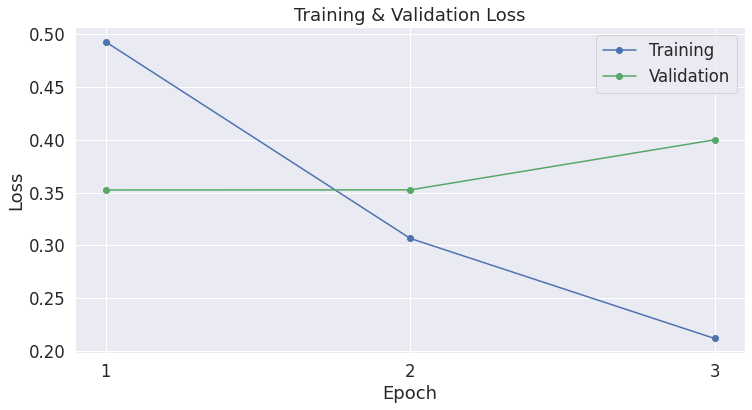

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Base Test

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/label.csv', error_bad_lines=False, sep=';', encoding = "ISO-8859-1")

In [0]:
df.sample(10)

,sentences_author,label
203,"face it mr blow, they fight dirty, they fight...",neutral
266,"the wall street journal leans conservative, ...",neutral
152,"<br/><br/>ross, your immodest proposals are a ...",negative
9,i've been a fan of mr. egan's writing for many...,negative
233,gail:<br/><br/>i wish i was amused by this opi...,neutral
226,thank you maureen dowd for putting the past we...,positive
196,"<br/><br/>moreover, methinks mr. douthat needs...",negative
109,i don't put david brooks in the main hall of a...,neutral
5,they aren't as stupid as dr. krugman and many...,negative
175,since that includes just about every republic...,positive


In [0]:
# Reshaping the data
df.rename(columns={'sentences_author':'text'},inplace=True)
df.loc[:,'labels'] = df.label.map({'negative':0,'neutral':2,'positive':1})
df = df.drop(['label'], axis=1)
df.head()

,text,labels
0,"frank, i'm typically in full alignment with yo...",2
1,i think professor krugman answered that ques...,1
2,""" <br/><br/>maureen has seen the greater truth...",1
3,"that said, i am with frank: a bit of real ""se...",1
4,another good article by edsall.,1


In [0]:
import re

def preprocess_sentence(sen):
	#Preprocess the text in a single sentence
	#convert the sentence to lower case
	sen.lower()
	#remove all urls
	sen = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',sen)
	#correct all multiple white spaces to a single white space
	sen = re.sub('[\s]+', ' ', sen)
	#convert "#topic" to just "topic"
	sen = re.sub(r'#([^\s]+)', r'\1', sen)
	return sen

def remove_html(sen):
  sen = re.sub('"<[^<]+?>', '', sen)
  return sen

def remove_hyphen(sen):
  sen = re.sub('\" ', '', sen)
  return sen

In [0]:
df['text'] = df['text'].apply(preprocess_sentence)
df['text'] = df['text'].apply(remove_html)
df['text'] = df['text'].apply(remove_hyphen)

In [0]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.text.values
labels = df.labels.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 300



In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 300 test sentences...
    DONE.


In [0]:
pred_labels = np.argmax(predictions[0], axis=1).flatten()
pred_labels

array([0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0,
       0, 2, 0, 2, 2, 0, 0, 1, 0, 1])

In [0]:
true_labels[0]

array([2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 1, 2,
       2, 2, 0, 2, 0, 0, 1, 2, 2, 0])

In [0]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
#mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

#print('Total MCC: %.3f' % mcc)

In [0]:
pred = pd.DataFrame(flat_predictions,columns=['value'])
true = pd.DataFrame(flat_true_labels,columns=['value'])

In [0]:
pred.loc[:,'y_pred'] = pred.value.map({0:'negative',2:'neutral',1:'positive'})
true.loc[:,'y_true'] = true.value.map({0:'negative',2:'neutral',1:'positive'})
pred = pred.drop(['value'], axis=1)
true = true.drop(['value'], axis=1)

In [0]:
pred.loc[:,'y_pred_negative'] = pred.y_pred.map({'negative':1,'neutral':0,'positive':0})
pred.loc[:,'y_pred_positive'] = pred.y_pred.map({'negative':0,'neutral':0,'positive':1})
pred.loc[:,'y_pred_neutral'] = pred.y_pred.map({'negative':0,'neutral':1,'positive':0})

In [0]:
true.loc[:,'y_true_negative'] = true.y_true.map({'negative':1,'neutral':0,'positive':0})
true.loc[:,'y_true_positive'] = true.y_true.map({'negative':0,'neutral':0,'positive':1})
true.loc[:,'y_true_neutral'] = true.y_true.map({'negative':0,'neutral':1,'positive':0})

In [0]:
y_pred2 = pd.DataFrame({"y_pred_negative": pred["y_pred_negative"], "y_pred_positive": pred["y_pred_positive"], "y_pred_neutral": pred["y_pred_neutral"]}).to_numpy()
y_true2 = pd.DataFrame({"y_true_negative": true["y_true_negative"], "y_true_positive": true["y_true_positive"], "y_true_neutral": true["y_true_neutral"]}).to_numpy()

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

def show_eval(y_true, y_pred):
  print( classification_report(y_true, y_pred) )
  cm = confusion_matrix(y_true, y_pred) 
  labels = ['negative', 'neutral', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

              precision    recall  f1-score   support

    negative       0.44      0.83      0.57        90
     neutral       0.58      0.35      0.44       112
    positive       0.84      0.53      0.65        98

    accuracy                           0.55       300
   macro avg       0.62      0.57      0.55       300
weighted avg       0.62      0.55      0.55       300



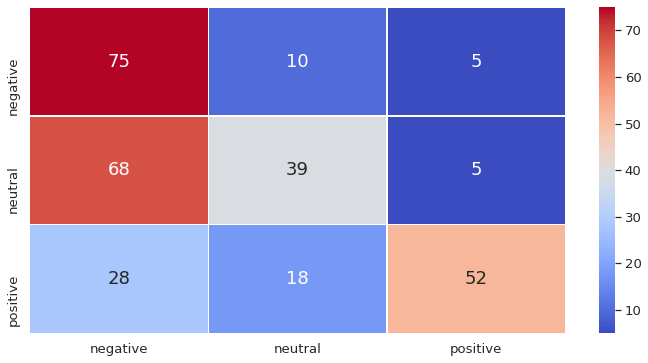

In [0]:
show_eval(np.array(true["y_true"]), np.array(pred["y_pred"]))

In [0]:
def ROC_plot(y_true, y_pred):  
  labels = ['negative', 'positive', 'neutral']
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

negative 0.6880952380952382
positive 0.7405536472014549
neutral 0.5996390577507598


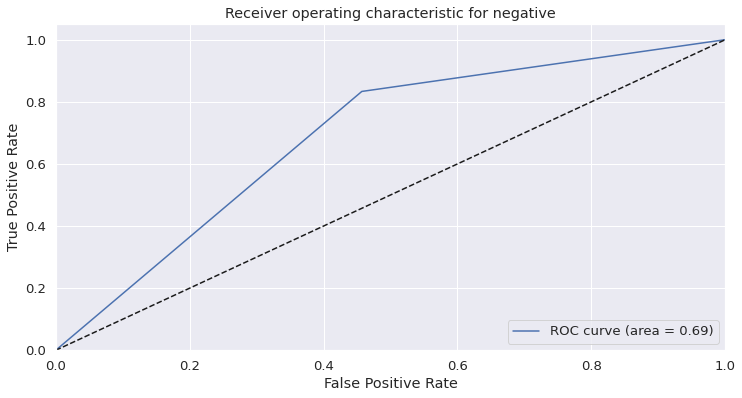

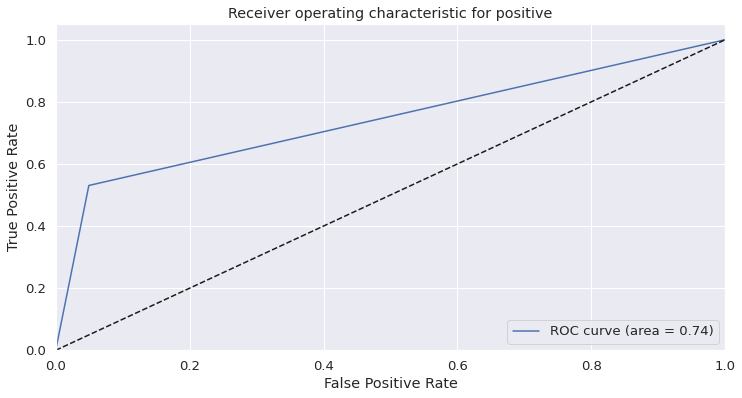

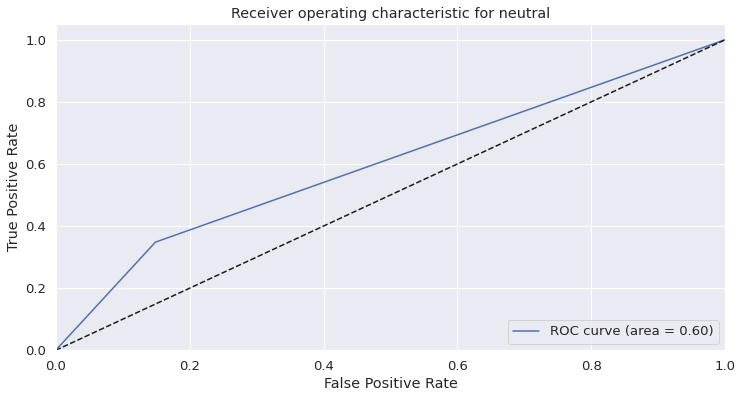

In [0]:
ROC_plot(y_true2,y_pred2)

In [0]:
df["predictions"] = flat_predictions

In [0]:
df.head()

,text,labels,predictions
0,"frank, i'm typically in full alignment with yo...",2,0
1,i think professor krugman answered that quest...,1,2
2,<br/><br/>maureen has seen the greater truth b...,1,0
3,"that said, i am with frank: a bit of real ""se...",1,0
4,another good article by edsall.,1,1


In [0]:
df_errors = df[df["labels"] != df["predictions"]]

In [0]:
df_errors.iloc[19]

NameError: ignored

In [0]:
df_errors["text"].iloc[120]

'the most sickening aspect of the speech, to me, was that which all the commentators, including mr. bruni are lauding, mr.'